In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt

In [2]:
from helper_fns_plotting import *

# LSFF: generate DALYs attributable to risk factors maps (on a log scale)

pulls shapefiles and estimates of DALYs attributable to:

RISKS
- iron deficiency
- total iron responsive anemia
- vitamin a deficiency
- zinc deficiency

CAUSES
- neural tube defects

plots choropleths with countries relevant to LSFF model, of dalys attributable in rate and absolute space, plotted on a log scale.

see 2021_01_15_LSFF_dalys_attributable_map and 2021_01_15_LSFF_dalys_attributable_map_topcoded for analogous maps that were either in linear space (normal) or linear space with a topcoded threshold

In [3]:
import geopandas as gpd, matplotlib as mpl, matplotlib.backends.backend_pdf

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world.name = world.name.astype(str)

world.loc[world.name=="Dem. Rep. Congo",'name'] = 'Democratic Republic of the Congo'
world.loc[world.name=="Tanzania",'name'] = 'United Republic of Tanzania'
world.rename(columns = {'name':'location_name'}, inplace=True)

In [4]:
def adjust_loc_names(df):    
    df = df[df.location_name!='Global']
    location_name_map = {    
        'Angola': 'Angola',
        'Bangladesh': 'Bangladesh',
        'Burkina Faso': 'Burkina Faso',
        "Côte d'Ivoire": "Côte d'Ivoire",
        'Cameroon': 'Cameroon',
        'China': 'China',
        'Democratic Republic of the Congo': 'Democratic Republic of the Congo',
        'Egypt': 'Egypt',
        'Ethiopia': 'Ethiopia',
        'Ghana': 'Ghana',
        'India': 'India',
        'Indonesia': 'Indonesia',
        'Kenya': 'Kenya',
        'Madagascar': 'Madagascar',
        'Mozambique': 'Mozambique',
        'Nepal': 'Nepal',
        'Nigeria': 'Nigeria',
        'Pakistan': 'Pakistan',
        'South Africa': 'South Africa',
        'Sudan': 'Sudan',
        'Uganda': 'Uganda',
        'United Republic of Tanzania': 'United Republic of Tanzania',
        'Viet Nam': 'Vietnam',
        'Myanmar': 'Myanmar',
        'Niger': 'Niger'
    }

    df.location_name = df.location_name.map(location_name_map)
    return df

In [5]:
def pull_iron():
    iron_path = '/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/inputs/iron_data_summary.csv'
    iron = pd.read_csv(iron_path)
    iron = pd.pivot_table(data = iron[(iron.parameter=="Total iron responsive anemia")&(iron.measure=="ylds")],
                  index = 'location_name',
                  columns = ['metric_id','age'],
                  values = 'mean')
    iron.columns = [' '.join(col).strip() for col in iron.columns.values]
    iron = iron.reset_index()

    rename_iron = {
     'count Reproductive age': 'mean_iron_dalys_reprod_age',
     'count Under Five': 'mean_iron_dalys_u5',
     'rate Reproductive age': 'mean_iron_dalys_per_100k_py_reprod_age',
     'rate Under Five': 'mean_iron_dalys_per_100k_py_u5'
    }
    iron = iron.rename(columns = rename_iron)

    ## scale up
    iron.mean_iron_dalys_per_100k_py_u5 = iron.mean_iron_dalys_per_100k_py_u5 * 100_000
    iron.mean_iron_dalys_per_100k_py_reprod_age = iron.mean_iron_dalys_per_100k_py_reprod_age * 100_000

    iron = adjust_loc_names(iron)
    return iron

In [6]:
def pull_ntd():
    ntd_path = '/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/inputs/ntd_data_summary.csv'
    ntd = pd.read_csv(ntd_path, encoding = 'iso-8859-1')

    rename_ntd = {
        'DALYs attributable to Neural tube defects in age group Under 5':'mean_ntd_dalys_u5',
        'DALYs attributable to Neural tube defects per 100,000 person-years in age group Under 5':'mean_ntd_dalys_per_100k_py_u5',
        "measure":"location_id",
        "Unnamed: 1":"location_name"
    }

    ntd = ntd.rename(columns=rename_ntd).iloc[2:]

    ntd.mean_ntd_dalys_u5 = ntd.mean_ntd_dalys_u5.astype(float)
    ntd.mean_ntd_dalys_per_100k_py_u5 = ntd.mean_ntd_dalys_per_100k_py_u5.astype(float)

    ntd = adjust_loc_names(ntd)
    return ntd

In [7]:
def pull_vad():
    vad_path = '/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/inputs/vitamin_a_data_summary.csv'
    vad = pd.read_csv(vad_path)
    vad = adjust_loc_names(vad)

    rename_vad = {
        "('dalys_attributable_to_vad_among_children_under_5', 'mean')":'mean_vad_dalys_u5',
        "('dalys_attributable_to_vad_per_100000_py_among_children_under_5', 'mean')":"mean_vad_dalys_per_100k_py_u5"
    }

    return vad.rename(columns=rename_vad)

In [8]:
def pull_zinc():
    zinc_path = '/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/inputs/zinc_data_summary.csv'
    zinc = pd.read_csv(zinc_path)

    rename_zinc = {
        "dalys_attributable_to_zinc_deficiency_in_age_group_1_to_4":'mean_zinc_dalys_1_4',
        "dalys_attributable_to_zinc_deficiency_per_100000_py_in_age_group_1_to_4":"mean_zinc_dalys_per_100k_py_u5",
        "measure":"location_id",
        "Unnamed: 1":"location_name"
    }
    zinc = zinc.rename(columns=rename_zinc).iloc[2:]

    zinc.mean_zinc_dalys_1_4 = zinc.mean_zinc_dalys_1_4.astype(float)
    zinc.mean_zinc_dalys_per_100k_py_u5 = zinc.mean_zinc_dalys_per_100k_py_u5.astype(float)
    
    zinc = adjust_loc_names(zinc)
    return zinc

In [9]:
def plot_map(shapefiles, title, var_name, step = 200, n_colors = 5):
    fig, ax = plt.subplots(figsize=(20,10))

    ax.set_aspect('equal')
    ax.set_title(title, fontsize = 24)
    
    ax.set_axis_off()
    
    # plot country outlines
    base = world[world.continent.isin(['Africa','Asia'])].plot(ax=ax, color='white', edgecolor='gray')

#     rf_df = shapefiles[shapefiles.Risk==risk_factor]
#     step = 50_000
    scale_max = step * n_colors

    # color in countries for which we have counts
    cmap = plt.cm.get_cmap('RdYlBu_r', n_colors) #colorscale, discretized to n_colors bins
    norm = mpl.colors.Normalize(vmin=0, vmax=scale_max) #normalize color scale
    # norm = mpl.colors.LogNorm(vmin=0, vmax=scale_max),
    me = shapefiles.plot(ax=base,
                         column=var_name,
                         cmap=cmap,
                         norm = norm, 
                         legend=True,
                         legend_kwds = {'ticks':np.arange(0,scale_max+1,step)},
                         edgecolor = 'gray')
#                          legend_kwds = {'ticks':np.arange(0,scale_max+(scale_max/n_colors),(scale_max)/n_colors)},

    return fig

In [10]:
def output_map(df, save_path, title, var_name, step, n_colors):
    
    assert(len(df[df.location_name.isna()])==0)
    assert len([i for i in df.location_name.unique() if i not in world.location_name.unique()])==0
    
    shapefiles = world.merge(df, on = 'location_name', how = 'right')
    pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)

    fig = plot_map(shapefiles = shapefiles, title = title, var_name = var_name, step = step, n_colors = n_colors)
    pdf.savefig(fig)

    pdf.close()

/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


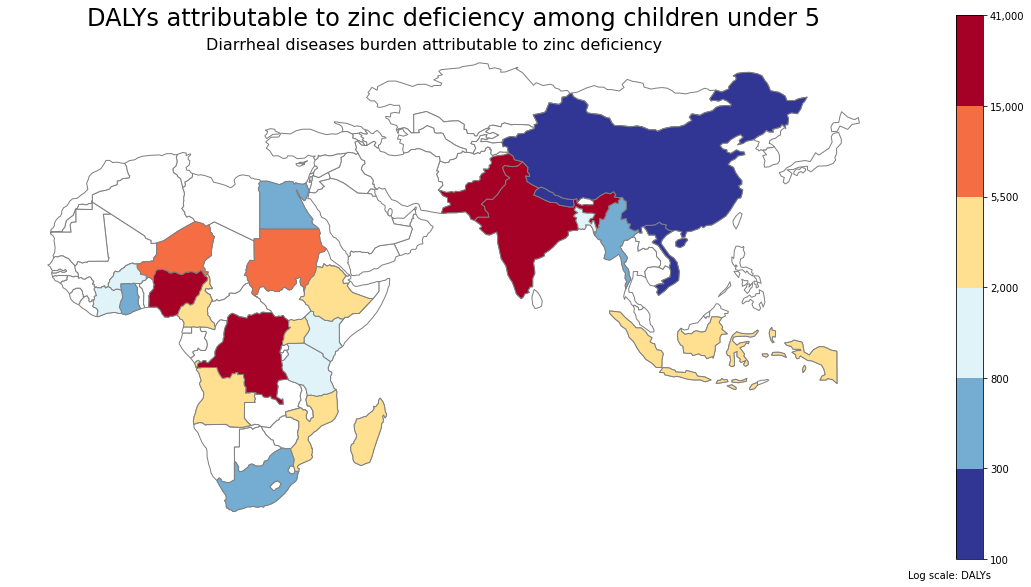

In [11]:
def plot_log_iron(shapefiles, risk, subtitle, var_name, n_colors = 5):
    fig, ax = plt.subplots(figsize=(20,10))

    ax.set_aspect('equal')
    ax.set_title(f'DALYs attributable to {risk} among children under 5', fontsize = 24, pad = 15)
    if subtitle!='NA':
        ax.text(60,59, subtitle, size=16, ha='center', va='center')
        
    ax.set_axis_off()
    
    # plot country outlines
    base = world[world.continent.isin(['Africa','Asia'])].plot(ax=ax, color='white', edgecolor='gray')

    scale_max = shapefiles[var_name].max()
    scale_min = shapefiles[var_name].min()


    # color in countries for which we have counts
    cmap = plt.cm.get_cmap('RdYlBu_r', n_colors) #colorscale, discretized to n_colors bins
    norm = mpl.colors.Normalize(vmin=scale_min, vmax=scale_max) #normalize color scale #normalize color scale
    me = shapefiles.plot(ax=base,
                         column=var_name,
                         cmap=cmap,
                         edgecolor = 'gray')
    
    ticks = np.arange(scale_min, scale_max+1, (scale_max - scale_min)/n_colors)
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=me, ticks = ticks)
    cbar.ax.set_yticklabels([add_commas(round_ticks(np.exp(i))) for i in ticks])
    #     cbar.ax.set_title('Log scale: rows of input data')
    cbar.set_label('Log scale: DALYs', labelpad=-75, y=-.02, rotation=0)

    return fig

save_path = '/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/outputs/plots/1_4_zinc_dalys_map.pdf'
# save_path = '/ihme/homes/beatrixh/repos/scratch/test_delete.pdf'
risk = 'zinc deficiency'
subtitle = 'Diarrheal diseases burden attributable to zinc deficiency'
var_name = 'mean_zinc_dalys_1_4'
step = 250_000
n_colors = 6


zinc_shapefiles = world.merge(pull_zinc(), on = 'location_name', how = 'right')
zinc_shapefiles = zinc_shapefiles[['continent','location_name','geometry','mean_zinc_dalys_1_4','mean_zinc_dalys_per_100k_py_u5']]
zinc_shapefiles['log_mean_zinc_dalys_1_4'] = np.log(zinc_shapefiles.mean_zinc_dalys_1_4)
zinc_shapefiles['log_mean_zinc_dalys_per_100k_py_u5'] = np.log(zinc_shapefiles.mean_zinc_dalys_per_100k_py_u5)

pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
fig = plot_log_iron(shapefiles = zinc_shapefiles, risk = risk, subtitle = subtitle, var_name = 'log_mean_zinc_dalys_1_4', n_colors = n_colors)
pdf.savefig(fig)
pdf.close()

/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


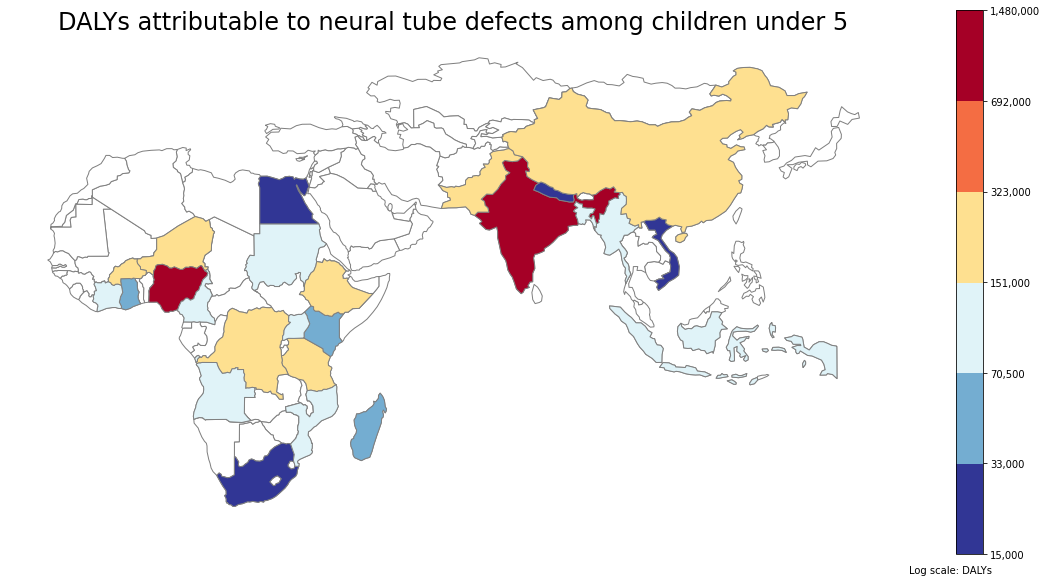

In [12]:
def plot_log_ntds(shapefiles, risk, var_name, n_colors = 5):
    fig, ax = plt.subplots(figsize=(20,10))

    ax.set_aspect('equal')
    ax.set_title(f'DALYs attributable to {risk} among children under 5', fontsize = 24)
    
    ax.set_axis_off()
    
    # plot country outlines
    base = world[world.continent.isin(['Africa','Asia'])].plot(ax=ax, color='white', edgecolor='gray')

    scale_max = ntd_shapefiles[var_name].max()
    scale_min = ntd_shapefiles[var_name].min()


    # color in countries for which we have counts
    cmap = plt.cm.get_cmap('RdYlBu_r', n_colors) #colorscale, discretized to n_colors bins
    norm = mpl.colors.Normalize(vmin=scale_min, vmax=scale_max) #normalize color scale #normalize color scale
    me = shapefiles.plot(ax=base,
                         column=var_name,
                         cmap=cmap,
                         edgecolor = 'gray')
    
    ticks = np.arange(scale_min, scale_max+1, (scale_max - scale_min)/n_colors)
    cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=me, ticks = ticks)
    cbar.ax.set_yticklabels([add_commas(round_ticks(np.exp(i))) for i in ticks])
    cbar.set_label('Log scale: DALYs', labelpad=-90, y=-.02, rotation=0)

    return fig

save_path = '/ihme/homes/beatrixh/notebooks/viv_rsc/data_prep/outputs/plots/mean_ntd_dalys_u5_map.pdf'
risk = 'neural tube defects'
var_name = 'log_mean_ntd_dalys_u5'
step = 250_000
n_colors = 6


ntd_shapefiles = world.merge(pull_ntd(), on = 'location_name', how = 'right')
ntd_shapefiles = ntd_shapefiles[['continent','location_name','geometry','mean_ntd_dalys_u5','mean_ntd_dalys_per_100k_py_u5']]
ntd_shapefiles['log_mean_ntd_dalys_u5'] = np.log(ntd_shapefiles.mean_ntd_dalys_u5)
ntd_shapefiles['log_mean_ntd_dalys_per_100k_py_u5'] = np.log(ntd_shapefiles.mean_ntd_dalys_per_100k_py_u5)

pdf = matplotlib.backends.backend_pdf.PdfPages(save_path)
fig = plot_log_ntds(shapefiles = ntd_shapefiles, risk = risk, var_name = var_name, n_colors = n_colors)
pdf.savefig(fig)
pdf.close()